In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('plag_data/features_all.csv')

In [3]:
df.head()

,Unnamed: 0,c_1,c_2,c_3,c_4,c_5,c_6,lcs_word
0,0,0.398148,0.079070,0.009346,0.000000,0.000000,0.000000,0.191781
1,1,1.000000,0.984694,0.964103,0.943299,0.922280,0.901042,0.820755
2,2,0.869369,0.719457,0.613636,0.515982,0.449541,0.382488,0.846491
3,3,0.593583,0.268817,0.156757,0.108696,0.081967,0.060440,0.316062
4,4,0.544503,0.115789,0.031746,0.005319,0.000000,0.000000,0.242574


In [4]:
df.columns

Index(['Unnamed: 0', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'lcs_word'], dtype='object')

In [35]:
df = df.drop(['Unnamed: 0'] , axis =1)

In [8]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::733184320490:role/service-role/AmazonSageMaker-ExecutionRole-20190808T091613


In [9]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-2-733184320490



In [10]:
prefix = 'plag_useful_features'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-2-733184320490/plag_useful_features/


In [37]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=6

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


In [36]:
# convert df to np array
train_data_np = df.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [38]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2019-08-27 13:35:10 Starting - Starting the training job...
2019-08-27 13:35:12 Starting - Launching requested ML instances...
2019-08-27 13:36:08 Starting - Preparing the instances for training.........
2019-08-27 13:37:34 Downloading - Downloading input data
2019-08-27 13:37:34 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[08/27/2019 13:37:50 INFO 140684264613696] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[08/27/2019 13:37:50 INFO 140684264613696] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'7', u'mini_batch_size': u'100', u'num_components': u'6'}
[08/27/2019 13:37:50 INFO 140684264613696]


2019-08-27 13:37:58 Uploading - Uploading generated training model
2019-08-27 13:37:58 Completed - Training job completed
Training seconds: 45
Billable seconds: 45
CPU times: user 368 ms, sys: 20.3 ms, total: 388 ms
Wall time: 3min 11s


In [39]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
import os
import boto3
training_job_name='pca-2019-08-27-13-35-10-597'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

plag_useful_features/pca-2019-08-27-13-35-10-597/output/model.tar.gz


2304

In [40]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[ 0.0463271   0.12057909  0.44920835  0.73960453  1.8658832  10.742833  ]
<NDArray 6 @cpu(0)>, 'v': 
[[ 0.00629231 -0.15013784 -0.28254795 -0.4741887  -0.73643667 -0.36108193]
 [-0.16333477  0.60254264 -0.45116276  0.49343988 -0.07442844 -0.3967208 ]
 [ 0.608253   -0.5019687  -0.227929    0.32384425  0.17990465 -0.3927725 ]
 [-0.5017588  -0.40680385 -0.0475      0.00105655  0.28088945 -0.3823402 ]
 [-0.3934908  -0.01061412  0.08127438 -0.26717788  0.32530612 -0.3717945 ]
 [ 0.44350737  0.4425421   0.16196133 -0.4944191   0.34564602 -0.36146474]
 [ 0.00383377  0.03135042  0.793457    0.33309412 -0.33994362 -0.37800834]]
<NDArray 7x6 @cpu(0)>, 'mean': 
[[0.5846998  0.31487542 0.22882585 0.19193812 0.16879173 0.15121938
  0.40050456]]
<NDArray 1x7 @cpu(0)>}


In [41]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [43]:
# looking at top 3 components
n_principal_components = 4

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

           0
2   0.449208
3   0.739605
4   1.865883
5  10.742833


In [44]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]


In [45]:
# test cell
import numpy as np
n_top_components = 3 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.99817413


In [46]:
# features
features_list = df.columns.values
print('Features: \n', features_list)

Features: 
 ['c_1' 'c_2' 'c_3' 'c_4' 'c_5' 'c_6' 'lcs_word']


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


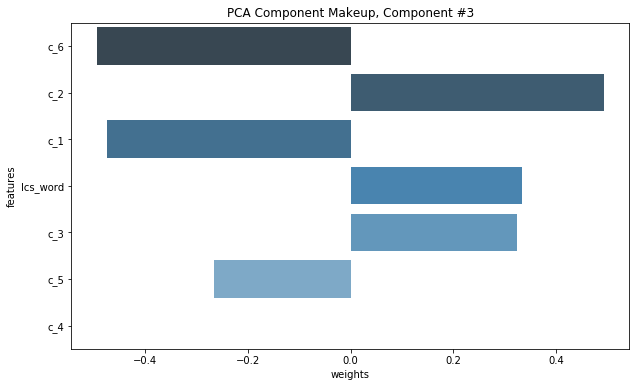

In [50]:
# display makeup of first component
num=3
display_component(v, df.columns.values, component_num=num, n_weights=10)